In [1]:
import torch
from torch import nn
import numpy as np
import sys
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import importlib

sys.path.append("..")
from model import BaselineTransformer
from data import get_database_path, read_h5_file
from utils import load_toml_config

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"
random_seed = 114514
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [2]:
EMD_config = load_toml_config("EMD")
particle_type_scale = EMD_config['particle_type_scale']

# Load raw events

In [3]:
files = load_toml_config("file")
database_path = get_database_path()

events = {}
for key, value in files.items():
    events[key] = read_h5_file(database_path, value)
    print(key, events[key].shape)

SM (13451915, 19, 4)
neutral_boson (55969, 19, 4)
leptoquark (340544, 19, 4)
neutral_Higgs (691283, 19, 4)
charged_Higgs (760272, 19, 4)


In [4]:
signals = [key for key in events.keys() if key != "SM"]
print(signals)

['neutral_boson', 'leptoquark', 'neutral_Higgs', 'charged_Higgs']


In [5]:
model_hyper_parameters = load_toml_config("Transformer")
print(model_hyper_parameters)
feature_size = model_hyper_parameters["feature_size"]
embed_size = model_hyper_parameters["embed_size"]
num_heads = model_hyper_parameters["num_heads"]
num_layers = model_hyper_parameters["num_layers"]
hidden_dim = model_hyper_parameters["hidden_dim"]


classify_model = BaselineTransformer(feature_size, embed_size, num_heads, hidden_dim, num_layers)
classify_model.to(device)

{'feature_size': 3, 'embed_size': 16, 'num_heads': 8, 'num_layers': 4, 'hidden_dim': 256, 'output_dim': 4}


/home/desmondhe/anaconda3/envs/ad/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


BaselineTransformer(
  (particle_embedding): Linear(in_features=3, out_features=16, bias=True)
  (pos_encoder): ParticlePositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=304, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# Split Events

In [6]:
from analysis import create_exp_bkg_events, train_test_split, get_dataloaders
from data import EventDataset

In [7]:
tpr_dict = {}
fpr_dict = {}
auc_dict = {}

In [33]:
test_ratio=0.2
val_ratio = 0.2
sig_lambda = 0
n = 100000

# test_signal = "neutral_boson"
# test_signal = "leptoquark"
# test_signal = "neutral_Higgs"
test_signal = "charged_Higgs"

exp_events, bkg_events = create_exp_bkg_events(events['SM'], events[test_signal], sig_lambda, n)
X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
n1 = len(W1)
m1 = len(X1)
pi = n1 / (n1 + m1)
n2 = len(W2)
m2 = len(X2)
train_dataloader, val_dataloader = get_dataloaders(X1[:,:,:3], W1[:, :, :3], val_ratio, )

# Train

In [34]:
from metrics import BinaryACCUpdater
classify_model.to(device)
optimizer = torch.optim.Adam(classify_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

In [35]:
from classify import train_model

In [36]:
train_model(
    classify_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50
    )


================================================================================2024-06-02 19:22:29
Epoch 1 / 50

100%|██████████| 125/125 [00:00<00:00, 355.88it/s, val_Accuracy=0.5, val_loss=0.693]    
<<<<<< reach best val_Accuracy : 0.5000937581062317 >>>>>>

================================================================================2024-06-02 19:22:44
Epoch 2 / 50

100%|██████████| 125/125 [00:00<00:00, 225.48it/s, val_Accuracy=0.5, val_loss=0.693]

================================================================================2024-06-02 19:22:59
Epoch 3 / 50

100%|██████████| 125/125 [00:00<00:00, 344.42it/s, val_Accuracy=0.5, val_loss=0.693]

================================================================================2024-06-02 19:23:15
Epoch 4 / 50

100%|██████████| 125/125 [00:00<00:00, 360.49it/s, val_Accuracy=0.5, val_loss=0.693]

================================================================================2024-06-02 19:23:30
Epoch 5 / 50

100%|██████████| 125/1

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,0.694114,0.500609,0.693210,0.500094,1
1,0.693408,0.499820,0.693183,0.500000,2
2,0.693343,0.499148,0.693224,0.500000,3
3,0.693275,0.501547,0.693281,0.500000,4
4,0.693284,0.500258,0.693153,0.500000,5
5,0.693297,0.499234,0.693177,0.500000,6


In [37]:
from analysis import predict

100%|██████████| 125/125 [00:00<00:00, 436.09it/s]


0.503596251953125


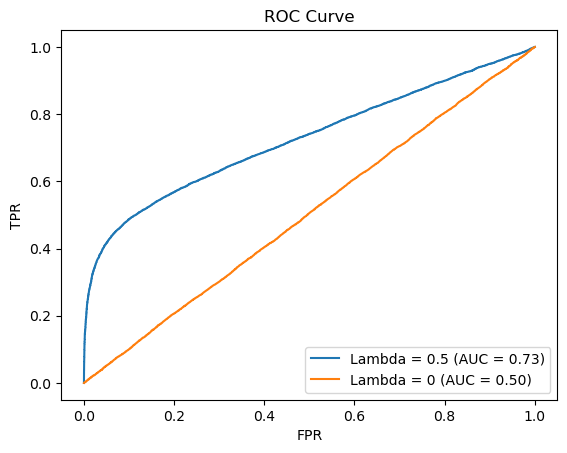

In [38]:
targets, predictions = predict(classify_model, val_dataloader)
from analysis import calculate_auc
from visualize import plot_roc_curve
fpr, tpr, auc_roc = calculate_auc(targets, predictions)
print(auc_roc)
fpr_dict[str(sig_lambda)] = fpr
tpr_dict[str(sig_lambda)] = tpr
auc_dict[str(sig_lambda)] = auc_roc
plot_roc_curve(fpr_dict, tpr_dict, auc_dict, "ROC Curve")

# Test Statistics

In [39]:
import analysis
import importlib
importlib.reload(analysis)
from analysis import Bootstrap_Permutation

In [40]:
bootstrap_permutation = Bootstrap_Permutation(X2[:,:,:3], W2[:,:,:3], classify_model, pi, normalizer=None)

In [45]:
lrt_null_bootstarp, auc_null_bootstarp, mce_null_bootstarp = bootstrap_permutation.bootstrap(10000)
lrt_null_permutation, auc_null_permutation, mce_null_permutation = bootstrap_permutation.permutation(10000)

100%|██████████| 10000/10000 [08:04<00:00, 20.65it/s] 


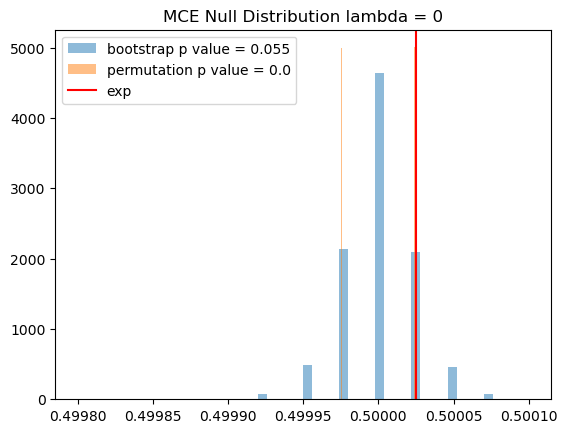

In [46]:
plt.hist(mce_null_bootstarp, bins=50, alpha=0.5, label="bootstrap p value = {}".format(bootstrap_permutation.mce_p_bootstrap))
plt.hist(mce_null_permutation, bins=50, alpha=0.5, label="permutation p value = {}".format(bootstrap_permutation.mce_p_permutation))
plt.axvline(bootstrap_permutation.mce_exp, color='r', label="exp")
plt.legend()
plt.title("MCE Null Distribution lambda = {}".format(sig_lambda))
plt.show()

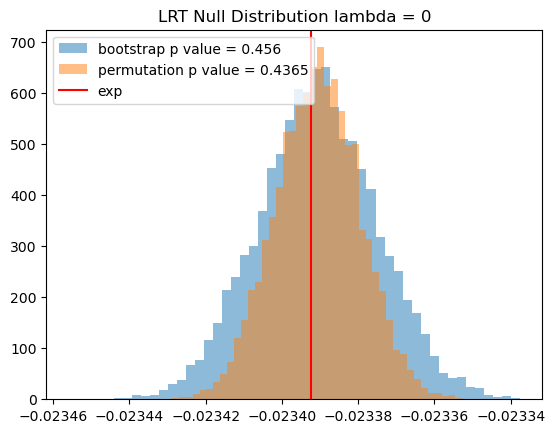

In [47]:
plt.hist(lrt_null_bootstarp, bins=50, alpha=0.5, label="bootstrap p value = {}".format(bootstrap_permutation.lrt_p_bootstrap))
plt.hist(lrt_null_permutation, bins=50, alpha=0.5, label="permutation p value = {}".format(bootstrap_permutation.lrt_p_permutation))
plt.axvline(bootstrap_permutation.lrt_exp, color='r', label="exp")
plt.legend()
plt.title("LRT Null Distribution lambda = {}".format(sig_lambda))
plt.show()

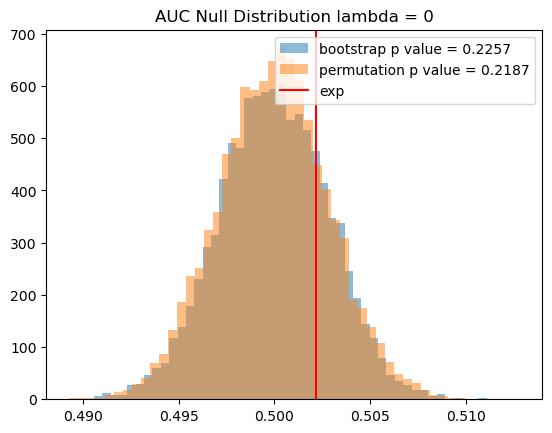

In [48]:
plt.hist(auc_null_bootstarp, bins=50, alpha=0.5, label="bootstrap p value = {}".format(bootstrap_permutation.auc_p_bootstrap))
plt.hist(auc_null_permutation, bins=50, alpha=0.5, label="permutation p value = {}".format(bootstrap_permutation.auc_p_permutation))
plt.axvline(bootstrap_permutation.auc_exp, color='r', label="exp")
plt.legend()
plt.title("AUC Null Distribution lambda = {}".format(sig_lambda))
plt.show()

# Estimate Signal Strength

In [20]:
from analysis import LambdaEstimator

estimated lambda: 0.4802727272727273
beta 0 = -0.6544510805165363, beta 1 = 0
last bin height: 0.5197272727272727


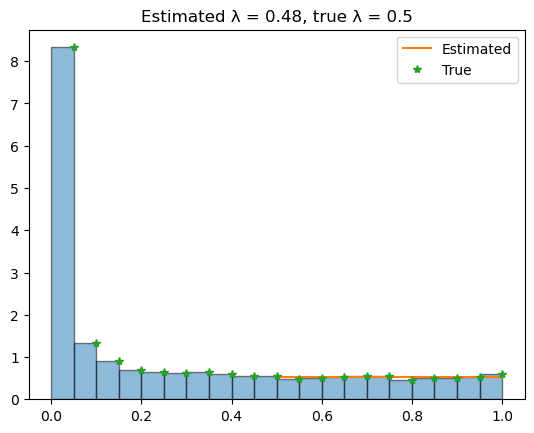

In [21]:
lambda_estimator = LambdaEstimator(X2[:,:,:3], W2[:,:,:3], classify_model, T=0.5, n_bins=20, normalizer=None)
print("estimated lambda:", lambda_estimator.estimated_lambda)
print("beta 0 = {}, beta 1 = {}".format(lambda_estimator.beta0, lambda_estimator.beta1))
print("last bin height:", lambda_estimator.estimated_H_t[-1])
plt.hist(lambda_estimator.rho_W, bins=lambda_estimator.bins, alpha=0.5, edgecolor='black', density=True)
start_idx = lambda_estimator.fit_start_idx
plt.plot(lambda_estimator.bins[start_idx:], lambda_estimator.estimated_H_t, label="Estimated")
plt.plot(lambda_estimator.bins[1:], lambda_estimator.H_t, '*',label="True")
plt.legend()
plt.title("Estimated λ = {:.2f}, true λ = {}".format(lambda_estimator.estimated_lambda, sig_lambda))
plt.show()

# Bootstrapped Uncertainty Intervals for λ

In [22]:
lambda_mean_dict = {}
lambda_std_dict = {}

lrt_p_permutation_dict = {}
lrt_p_bootstrap_dict = {}
auc_p_permutation_dict = {}
auc_p_bootstrap_dict = {}
mce_p_permutation_dict = {}
mce_p_bootstrap_dict = {}

In [23]:
import importlib
import classify
import analysis
importlib.reload(classify)
importlib.reload(analysis)
from classify import train_model
from analysis import Bootstrap_Permutation
opt_train_model  = torch.compile(train_model)

In [24]:

classify_model = BaselineTransformer(feature_size, embed_size, num_heads, hidden_dim, num_layers)
classify_model.to(device)

/home/desmondhe/anaconda3/envs/ad/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


BaselineTransformer(
  (particle_embedding): Linear(in_features=3, out_features=16, bias=True)
  (pos_encoder): ParticlePositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=304, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [25]:
n_bootstrap = 10


test_ratio=0.2
val_ratio = 0.2
n = 100000
n_null = 1000

# test_signal = "neutral_boson"
# test_signal = "leptoquark"
# test_signal = "neutral_Higgs"
test_signal = "charged_Higgs"
significance = 0.05


test_lambdas = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
for i in range(len(test_lambdas)):
    sig_lambda = test_lambdas[i]

    estimated_lambdas = np.zeros(n_bootstrap)

    lrt_permutation_power = 0
    lrt_bootstrap_power = 0
    auc_permutation_power = 0
    auc_bootstrap_power = 0
    mce_permutation_power = 0
    mce_bootstrap_power = 0
    for j in range(n_bootstrap):
        exp_events, bkg_events = create_exp_bkg_events(events['SM'], events[test_signal], sig_lambda, n)
        X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
        train_dataloader, val_dataloader = get_dataloaders(X1[:,:,:3], W1[:,:,:3], val_ratio, None)

        classify_model = BaselineTransformer(feature_size, embed_size, num_heads, hidden_dim, num_layers)
        classify_model.to(device)
        optimizer = torch.optim.Adam(classify_model.parameters(), lr=1e-3, weight_decay=1e-5)
        loss_fn = nn.BCELoss()
        acc_metric = BinaryACCUpdater()
        metric_dict = {"Accuracy": acc_metric}

        train_model(
            classify_model, optimizer,
            loss_fn, metrics_dict=metric_dict,
            train_dataloader=train_dataloader, val_dataloader=val_dataloader,
            monitor="val_Accuracy", mode="max",
            epochs=50,
            verbose=False
            )
        
        bootstrap_permutation = Bootstrap_Permutation(X2[:,:,:3], W2[:,:,:3], classify_model, pi, None)
        _, _, _ = bootstrap_permutation.bootstrap(n_null, verbose=False)
        _, _, _ = bootstrap_permutation.permutation(n_null, verbose=False)
        if bootstrap_permutation.lrt_p_permutation < significance:
            lrt_permutation_power += 1
        if bootstrap_permutation.lrt_p_bootstrap < significance:
            lrt_bootstrap_power += 1
        if bootstrap_permutation.auc_p_permutation < significance:
            auc_permutation_power += 1
        if bootstrap_permutation.auc_p_bootstrap < significance:
            auc_bootstrap_power += 1
        if bootstrap_permutation.mce_p_permutation < significance:
            mce_permutation_power += 1
        if bootstrap_permutation.mce_p_bootstrap < significance:
            mce_bootstrap_power += 1

        lambda_estimator = LambdaEstimator(X2[:,:,:3], W2[:,:,:3], classify_model, T=0.5, n_bins=20, normalizer=None)
        estimated_lambdas[j] = lambda_estimator.estimated_lambda
    print("sig_lambda:", sig_lambda, "estimated lambda mean:", estimated_lambdas.mean(), "estimated lambda std:", estimated_lambdas.std())
    lambda_mean_dict[str(sig_lambda)] = estimated_lambdas.mean()
    lambda_std_dict[str(sig_lambda)] = estimated_lambdas.std(ddof = 1)
    lrt_p_permutation_dict[str(sig_lambda)] = lrt_permutation_power
    lrt_p_bootstrap_dict[str(sig_lambda)] = lrt_bootstrap_power
    auc_p_permutation_dict[str(sig_lambda)] = auc_permutation_power
    auc_p_bootstrap_dict[str(sig_lambda)] = auc_bootstrap_power
    mce_p_permutation_dict[str(sig_lambda)] = mce_permutation_power
    mce_p_bootstrap_dict[str(sig_lambda)] = mce_bootstrap_power


<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
sig_lambda: 0 estimated lambda mean: 0.0036773253159850363 estimated lambda std: 0.01263908858744742
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_Accuracy without improvement in 5 epoch, early stopping >>>>>>
<<<<<< val_

In [26]:
import visualize
importlib.reload(visualize)
from visualize import plot_lambda

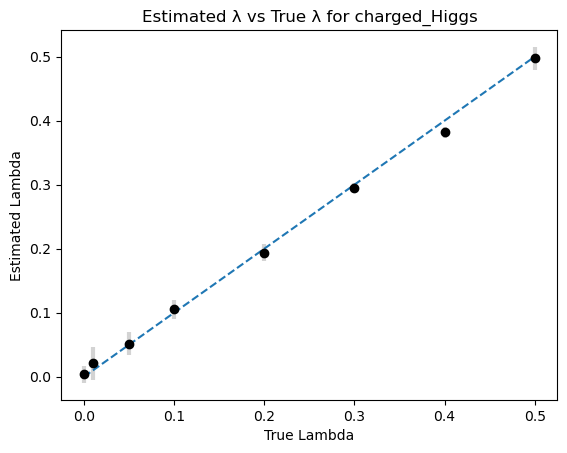

In [27]:
plot_lambda(lambda_mean_dict, lambda_std_dict, test_signal)

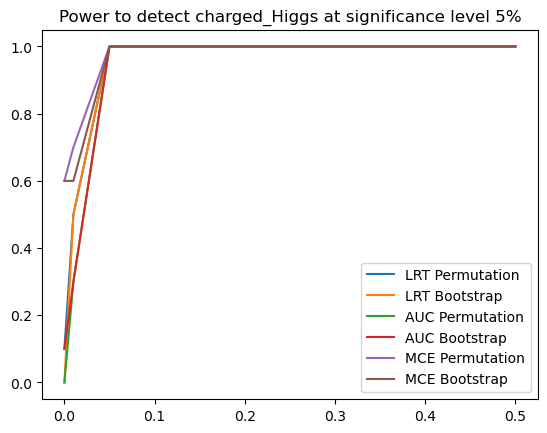

In [28]:
plt.plot(test_lambdas, np.array([lrt_p_permutation_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="LRT Permutation")
plt.plot(test_lambdas, np.array([lrt_p_bootstrap_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="LRT Bootstrap")
plt.plot(test_lambdas, np.array([auc_p_permutation_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="AUC Permutation")
plt.plot(test_lambdas, np.array([auc_p_bootstrap_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="AUC Bootstrap")
plt.plot(test_lambdas, np.array([mce_p_permutation_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="MCE Permutation")
plt.plot(test_lambdas, np.array([mce_p_bootstrap_dict[str(sig_lambda)] for sig_lambda in test_lambdas])/n_bootstrap, label="MCE Bootstrap")
plt.title("Power to detect {} at significance level {:.0%}".format(test_signal, significance))
plt.legend()
plt.show()

In [29]:
import pandas as pd
power_df = pd.DataFrame(columns=test_lambdas)
power_df.loc["LRT Permutation"] = [lrt_p_permutation_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["LRT Bootstrap"] = [lrt_p_bootstrap_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["AUC Permutation"] = [auc_p_permutation_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["AUC Bootstrap"] = [auc_p_bootstrap_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["MCE Permutation"] = [mce_p_permutation_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]
power_df.loc["MCE Bootstrap"] = [mce_p_bootstrap_dict[str(sig_lambda)]/n_bootstrap for sig_lambda in test_lambdas]

In [49]:
h5file_name = "baseline_lambda_estimator_{}.h5".format(test_signal)
with pd.HDFStore(h5file_name) as store:
    store["power_df"] = power_df
    store["lambda_mean_dict"] = pd.Series(lambda_mean_dict)
    store["lambda_std_dict"] = pd.Series(lambda_std_dict)

In [32]:
h5 = pd.HDFStore(h5file_name)
for key in h5.keys():
    print(key)
    print(h5[key])

/lambda_mean_dict
0       0.003677
0.01    0.020730
0.05    0.051404
0.1     0.105420
0.2     0.193822
0.3     0.294951
0.4     0.382105
0.5     0.497268
dtype: float64
/lambda_std_dict
0       0.013323
0.01    0.026111
0.05    0.018219
0.1     0.014991
0.2     0.013600
0.3     0.007034
0.4     0.008665
0.5     0.017790
dtype: float64
/power_df
                 0.00  0.01  0.05  0.10  0.20  0.30  0.40  0.50
LRT Permutation   0.1   0.5   1.0   1.0   1.0   1.0   1.0   1.0
LRT Bootstrap     0.0   0.5   1.0   1.0   1.0   1.0   1.0   1.0
AUC Permutation   0.0   0.3   1.0   1.0   1.0   1.0   1.0   1.0
AUC Bootstrap     0.1   0.3   1.0   1.0   1.0   1.0   1.0   1.0
MCE Permutation   0.6   0.7   1.0   1.0   1.0   1.0   1.0   1.0
MCE Bootstrap     0.6   0.6   1.0   1.0   1.0   1.0   1.0   1.0
